<a href="https://colab.research.google.com/github/jAndrewtomich/2020-US-Elections/blob/main/2020_presidential_votes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install langdetect
!pip install geopandas
!pip install kaggle

     |████████████████████████████████| 983kB 5.8MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-cp36-none-any.whl size=993195 sha256=255c355b506c0f505f7baa02f68e70f16663ec0d738c7a5bd0bfe85fe4650854
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
Successfully built langdetect
     |████████████████████████████████| 972kB 5.6MB/s 
     |████████████████████████████████| 6.5MB 13.1MB/s 
     |████████████████████████████████| 14.8MB 311kB/s 


In [2]:
import os
import zipfile
import time
import missingno as msno
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import nltk, re, string, collections, unicodedata

%matplotlib inline
from matplotlib import cm, dates
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
from datetime import datetime, timedelta
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
from langdetect import detect
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer

/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [3]:
#Set the enviroment variables

os.environ['KAGGLE_USERNAME'] = "xxxx"
os.environ['KAGGLE_KEY'] = "xxxxx"
!kaggle datasets download -d unanimad/us-election-2020
!kaggle datasets download -d manchunhui/us-election-2020-tweets

zip_ref = zipfile.ZipFile('us-election-2020.zip', 'r')
zip_ref.extractall()
zip_ref.close()

zip_ref = zipfile.ZipFile('us-election-2020-tweets.zip', 'r')
zip_ref.extractall()
zip_ref.close()

  0% 0.00/429k [00:00<?, ?B/s]
100% 429k/429k [00:00<00:00, 63.9MB/s]
 98% 346M/353M [00:02<00:00, 133MB/s]
100% 353M/353M [00:02<00:00, 132MB/s]


In [4]:
president_county_candidate_df = pd.read_csv('president_county_candidate.csv')

In [5]:
president_county_candidate_df.loc[(president_county_candidate_df.candidate == ' Write-ins'), 'candidate'] = 'Write-ins'

In [6]:
#aggregate votes by state

state_votes_df = president_county_candidate_df.groupby(['state', 'candidate']).total_votes.sum()
state_votes_df = pd.DataFrame(state_votes_df).reset_index()

In [7]:
interests_df = state_votes_df[(state_votes_df.candidate == 'Joe Biden') | (state_votes_df.candidate == 'Donald Trump') | (state_votes_df.candidate == 'Jo Jorgensen') | 
                              (state_votes_df.candidate == 'Write-ins') | (state_votes_df.candidate == 'Kanye West')]

In [8]:
trump_df = interests_df[interests_df.candidate == 'Donald Trump'].reset_index()
trump_df = trump_df.drop('index', axis=1)
biden_df = interests_df[interests_df.candidate == 'Joe Biden'].reset_index()
biden_df = biden_df.drop('index', axis=1)
jorgensen_df = interests_df[interests_df.candidate == 'Jo Jorgensen'].reset_index()
jorgensen_df = jorgensen_df.drop('index', axis=1)
west_df = interests_df[interests_df.candidate == 'Kanye West'].reset_index()
west_df = west_df.drop('index', axis = 1)
writeins_df = interests_df[interests_df.candidate == 'Write-ins'].reset_index()
writeins_df = writeins_df.drop('index', axis = 1)

In [9]:
def extend_data_wi(df):
  result_df = df
  for s in list(trump_df.state):
    if s not in list(df.state):
      result_df = result_df.append({'state':s, 'candidate':'Write-ins', 'total_votes':0}, ignore_index=True)
  return result_df

def extend_data_we(df):
  result_df = df
  for s in list(trump_df.state):
    if s not in list(df.state):
      result_df = result_df.append({'state':s, 'candidate':'Kanye West', 'total_votes':0}, ignore_index=True)
  return result_df

In [10]:
west_df = extend_data_we(west_df)

writeins_df = extend_data_wi(writeins_df)

In [11]:
sns.set_style("darkgrid")
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (20, 12)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

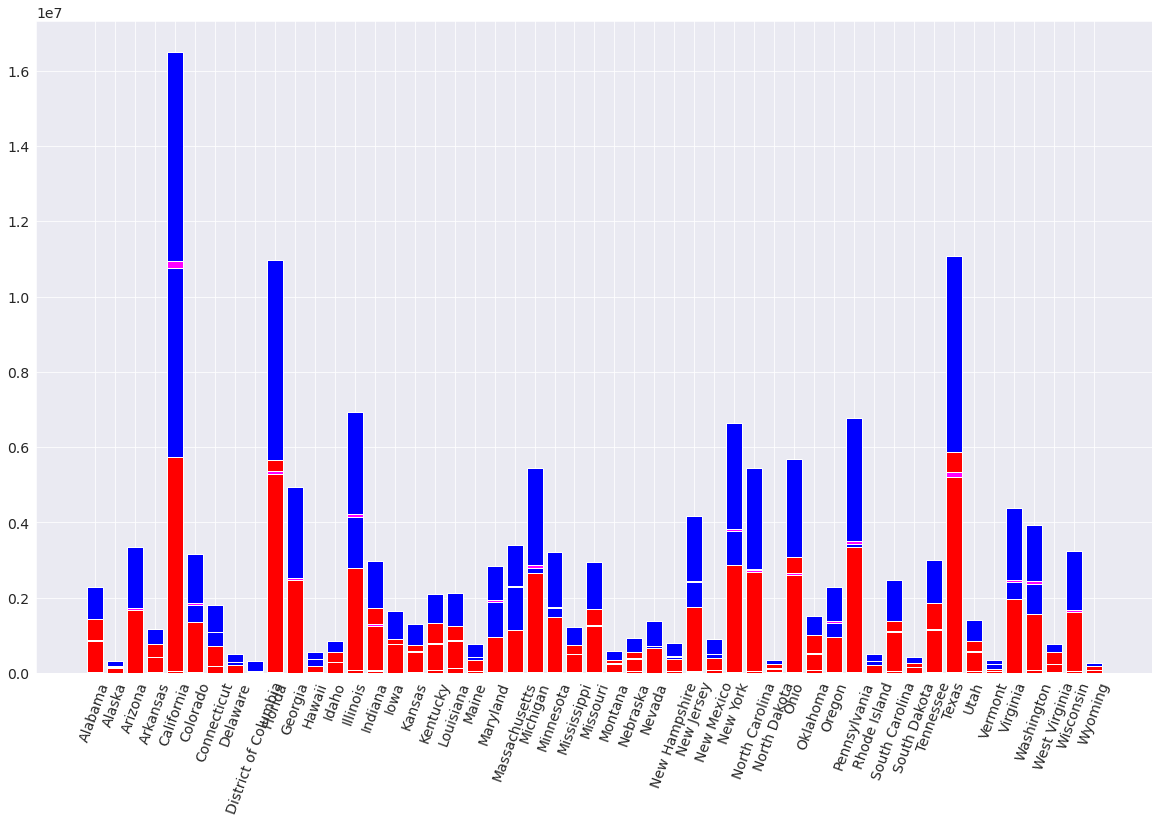

In [14]:
plt.xticks(rotation=70)
plt.bar(trump_df.state, trump_df.total_votes, color='red')
plt.bar(biden_df.state, biden_df.total_votes, color='blue', bottom=trump_df.total_votes)
plt.bar(jorgensen_df.state, jorgensen_df.total_votes, color='magenta', bottom=biden_df.total_votes)
plt.bar(writeins_df.state, writeins_df.total_votes, color='cyan', bottom=jorgensen_df.total_votes);

# The following is largely lifted directly from the excellent notebook at https://www.kaggle.com/manchunhui/us-presidential-election-sentiment-analysis
# I am changing and adding things for learning purposes.

In [34]:
# Reading both the csv files
tweets_biden_df = pd.read_csv('hashtag_joebiden.csv', lineterminator='\n', parse_dates=True)
tweets_trump_df = pd.read_csv('hashtag_donaldtrump.csv', lineterminator='\n', parse_dates=True)

In [35]:
tweets_trump_df['country'].replace({'United States of America':'United States'}, inplace=True)
tweets_biden_df['country'].replace({'United States of America':'United States'}, inplace=True)

In [36]:
# Add Features
def normalise(x,y):
    x = np.array(x)
    y = np.array(y)
    return np.where(x == 0, 0, x / y)

def sentiment(data):
    temp=[]
    for row in data:
        tmp=sid.polarity_scores(row)
        temp.append(tmp)
    return temp

# convert to datetime object
tweets_biden_df['user_join_date']=pd.to_datetime(tweets_biden_df['user_join_date'])
tweets_trump_df['user_join_date']=pd.to_datetime(tweets_trump_df['user_join_date'])
tweets_biden_df['collected_at']=pd.to_datetime(tweets_biden_df['collected_at'])
tweets_trump_df['collected_at']=pd.to_datetime(tweets_trump_df['collected_at'])
tweets_biden_df['created_at']=pd.to_datetime(tweets_biden_df['created_at'])
tweets_trump_df['created_at']=pd.to_datetime(tweets_trump_df['created_at'])

# create additional date time columns
tweets_biden_df['created_at_r']=tweets_biden_df['created_at'].dt.strftime('%Y-%m-%d %H')
tweets_trump_df['created_at_r']=tweets_trump_df['created_at'].dt.strftime('%Y-%m-%d %H')
tweets_biden_df['created_at_r2']=tweets_biden_df['created_at'].dt.strftime('%m-%d')
tweets_trump_df['created_at_r2']=tweets_trump_df['created_at'].dt.strftime('%m-%d')

# normalise likes and retweets to allow fair analysis
b_tdiff=(tweets_biden_df['collected_at'] - tweets_biden_df['created_at'])
t_tdiff=(tweets_trump_df['collected_at'] - tweets_trump_df['created_at'])
b_tdiff=(b_tdiff.dt.days * 24 + b_tdiff.dt.seconds / 3600)
t_tdiff=(t_tdiff.dt.days * 24 + t_tdiff.dt.seconds / 3600)

# Use numpy vectorisation to create new columns for normalised likes and retweets
tweets_biden_df['likes_norm'] = normalise(tweets_biden_df['likes'],b_tdiff)
tweets_biden_df['retweet_norm'] = normalise(tweets_biden_df['retweet_count'],b_tdiff)
tweets_trump_df['likes_norm'] = normalise(tweets_trump_df['likes'],t_tdiff)
tweets_trump_df['retweet_norm'] = normalise(tweets_trump_df['retweet_count'],t_tdiff)

In [19]:
# Visualisation args
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
barcolors = ['#87B88C','#9ED2A1','#E7E8CB','#48A0C9','#2A58A1','#2E8B55','#DF3659','Grey']
barstyle = {"edgecolor":"black", "linewidth":1}
heatmap1_args = dict(annot=True, fmt='.0f', square=False, cmap=cm.get_cmap("RdGy", 10), center = 90, vmin=0, vmax=10000, lw=4, cbar=False)
heatmap2_args = dict(annot=True, fmt='.3f', square=False, cmap="Greens", center = 0.5, lw=4, cbar=False)
heatmap3_args = dict(annot=True, fmt='.0f', square=False, cmap=cmap, center = 9200, lw=4, cbar=False)

def hide_axes(this_ax):
    this_ax.set_frame_on(False)
    this_ax.set_xticks([])
    this_ax.set_yticks([])
    return this_ax

def draw_heatmap1(df,this_ax):
    hm = sns.heatmap(df, ax = this_ax, **heatmap1_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top','bottom','left','right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm 

def draw_heatmap2(df,this_ax):
    hm = sns.heatmap(df, ax = this_ax, **heatmap2_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top','bottom','left','right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm 

def draw_heatmap3(df,this_ax):
    hm = sns.heatmap(df, ax = this_ax, **heatmap3_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top','bottom','left','right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm 

def thousands1(x, pos):
    'The two args are the value and tick position'
    return '%1.0fK' % (x * 1e-3)

formatterK1 = FuncFormatter(thousands1)

def thousands2(x, pos):
    'The two args are the value and tick position'
    return '%1.1fK' % (x * 1e-3)

formatterK2 = FuncFormatter(thousands2)

In [20]:
na_vals_b=pd.DataFrame({'Null Values':tweets_biden_df.isna().sum()})
na_vals_b=na_vals_b.loc[na_vals_b['Null Values'] > 0]
na_vals_t=pd.DataFrame({'Null Values':tweets_trump_df.isna().sum()})
na_vals_t=na_vals_t.loc[na_vals_t['Null Values'] > 0]

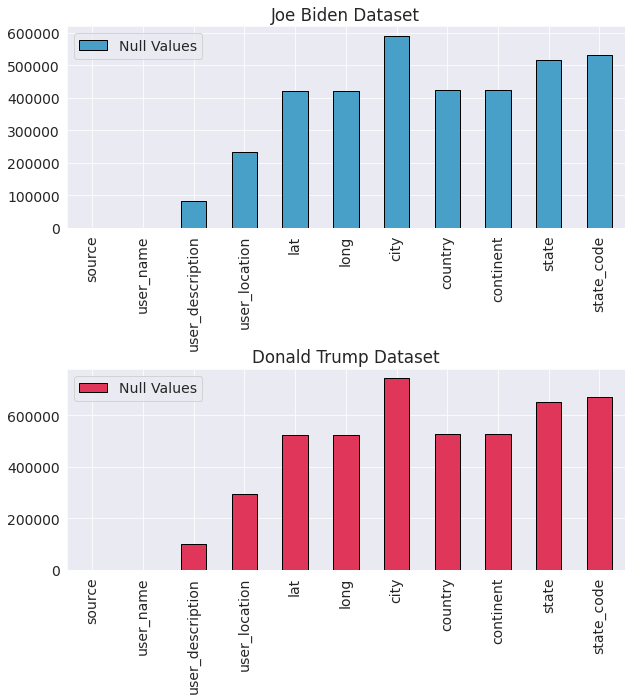

In [21]:
# Null values visualisation for tweets about Joe Biden and Donald Trump
fig, ax=plt.subplots(2,1, figsize=(10,10), gridspec_kw={'hspace':0.7})

na_vals_b.plot.bar(color=barcolors[3], **barstyle, ax=ax[0])
ax[0].set_title('Joe Biden Dataset')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)

na_vals_t.plot.bar(color=barcolors[6], **barstyle, ax=ax[1])
ax[1].set_title('Donald Trump Dataset')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
plt.show()

In [22]:
world=gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
from shapely.geometry import Point, Polygon
crs = {'init': 'EPSG:4326'}

tmp=pd.concat([tweets_biden_df[['lat','long']].copy(),tweets_trump_df[['lat','long']].copy()])
tmp=tmp.dropna()
geometry = [Point(xy) for xy in zip(tmp['long'],tmp['lat'])]
geo_df=gpd.GeoDataFrame(tmp, crs=crs, geometry = geometry)

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


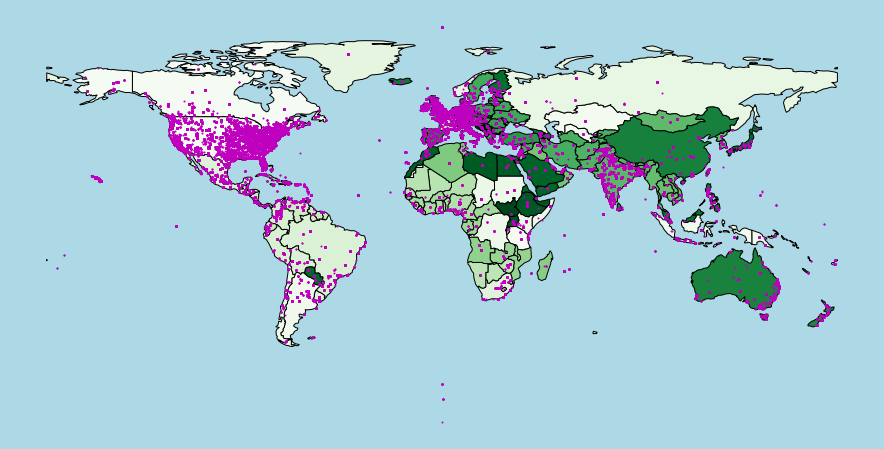

In [23]:
fig, ax = plt.subplots(1,figsize=(16,8), facecolor='lightblue')
world = world[world.name != "Antarctica"]
world.plot(ax=ax, cmap='Greens', edgecolors='black')
geo_df.plot(ax=ax, markersize=1, color='m', marker='o')
ax.axis('off')
plt.show()

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


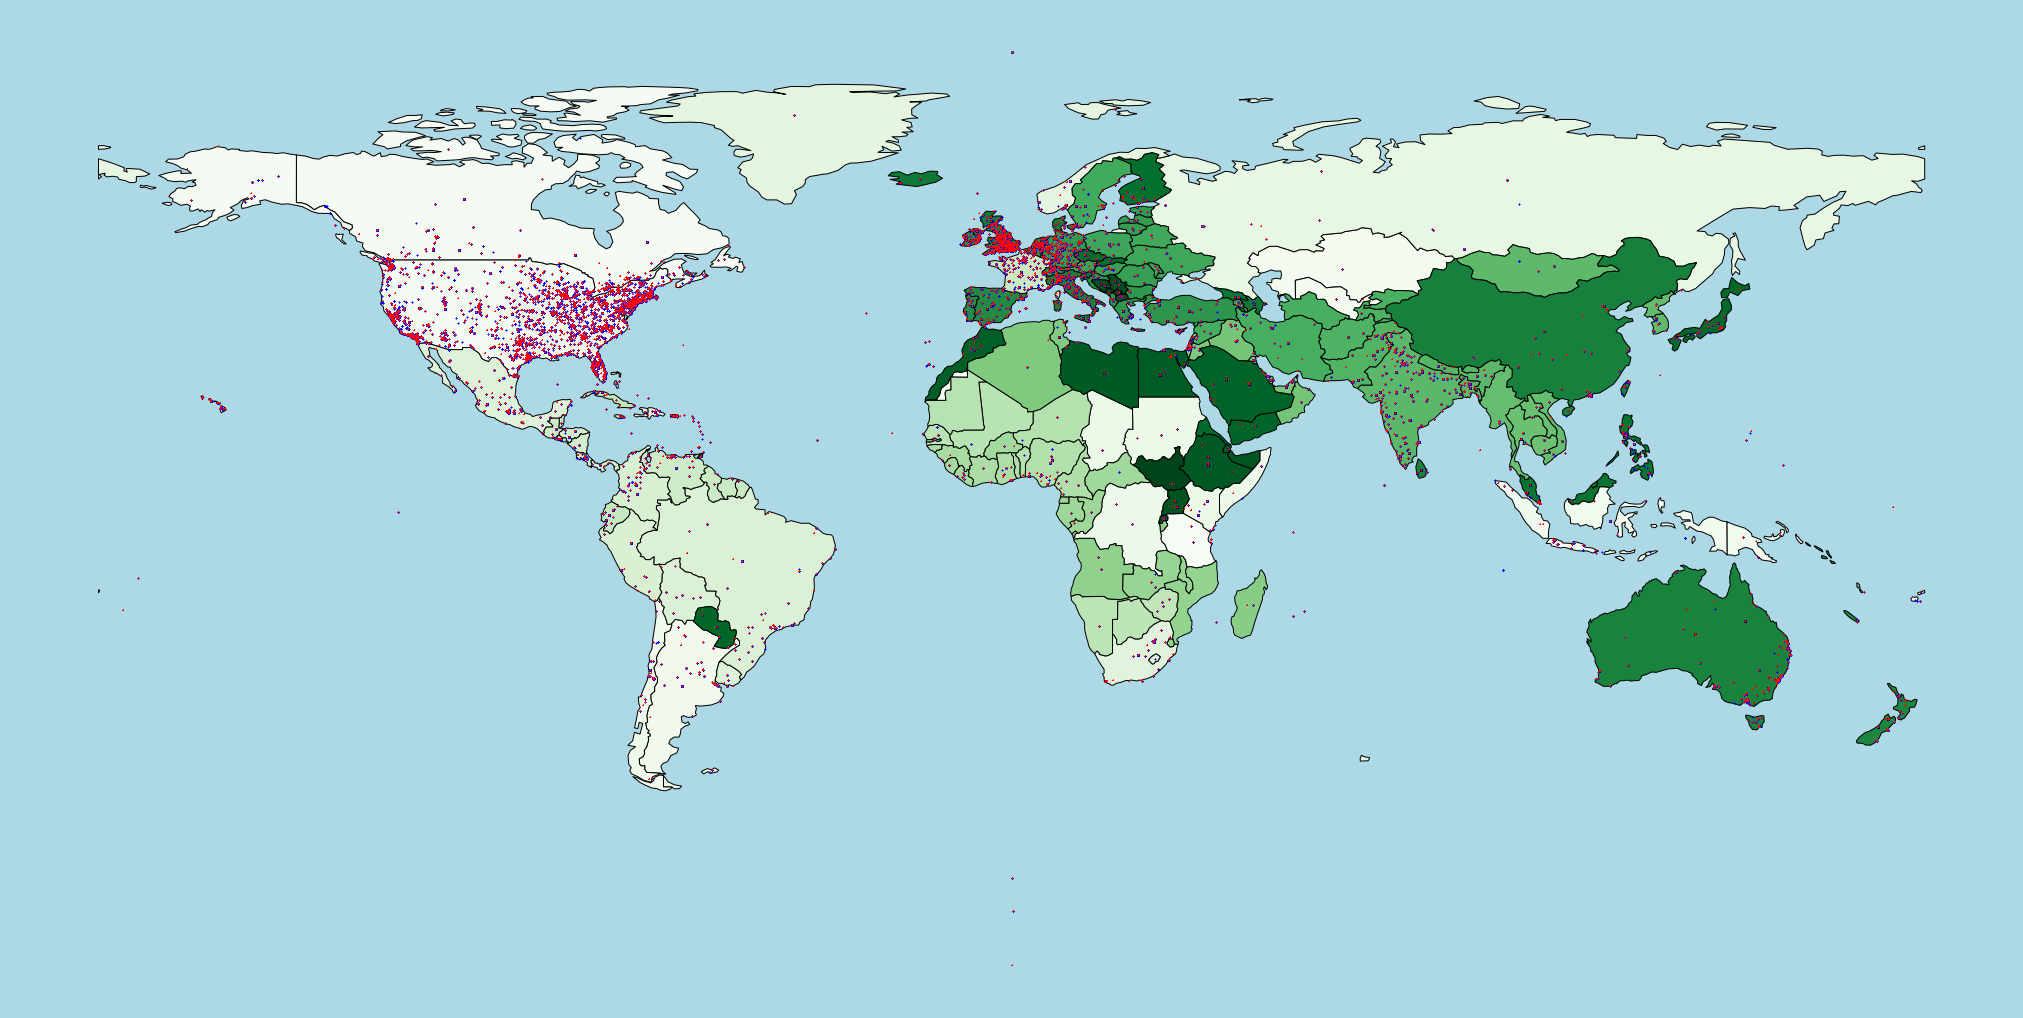

In [24]:
tmp=tweets_biden_df[['lat','long']].copy()
tmp=tmp.dropna()
geometry = [Point(xy) for xy in zip(tmp['long'],tmp['lat'])]
geo_df=gpd.GeoDataFrame(tmp, crs=crs, geometry = geometry)

tmp1=tweets_trump_df[['lat','long']].copy()
tmp1=tmp1.dropna()
geometry1 = [Point(xy) for xy in zip(tmp1['long'],tmp1['lat'])]
geo_df1=gpd.GeoDataFrame(tmp1, crs=crs, geometry = geometry1)

fig, ax = plt.subplots(1,figsize=(36,32), facecolor='lightblue')
world = world[world.name != "Antarctica"]
world.plot(ax=ax, cmap='Greens', edgecolors='black');
geo_df.plot(ax=ax, markersize=1, color='b', marker='x');
geo_df1.plot(ax=ax, markersize=1, color='r', marker='+');
ax.axis('off')
plt.show()

In [44]:
df1 = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2014_us_cities.csv')
df1 = df1.rename({'name':'city'}, axis=1)
df1

,city,pop,lat,lon
0,New York,8287238,40.730599,-73.986581
1,Los Angeles,3826423,34.053717,-118.242727
2,Chicago,2705627,41.875555,-87.624421
3,Houston,2129784,29.758938,-95.367697
4,Philadelphia,1539313,39.952335,-75.163789
...,...,...,...,...
3223,Spanish Fort,7102,30.674913,-87.915272
3224,Plaquemine,7102,30.289083,-91.234274
3225,Milton-Freewater,7102,45.932635,-118.387743
3226,Benton,7096,36.034529,-88.101285


In [ ]:
import plotly.graph_objects as go

import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2014_us_cities.csv')
df.head()

df['text'] = df['name'] + '<br>Population ' + (df['pop']/1e6).astype(str)+' million'
limits = [(0,2),(3,10),(11,20),(21,50),(50,3000)]
colors = ["royalblue","crimson","lightseagreen","orange","lightgrey"]
cities = []
scale = 5000

fig = go.Figure()

for i in range(len(limits)):
    lim = limits[i]
    df_sub = df[lim[0]:lim[1]]
    fig.add_trace(go.Scattergeo(
        locationmode = 'USA-states',
        lon = tweets_trump_df['long'],
        lat = tweets_trump_df['lat'],
        #text = df_sub['text'],
        marker = dict(
            size = df_sub['pop']/scale,
            color = colors[i],
            line_color='rgb(40,40,40)',
            line_width=0.5,
            sizemode = 'area'
        ),
        name = '{0} - {1}'.format(limits[(len(limits)-1) - i][0],limits[(len(limits)-1) - i][1])))

fig.update_layout(
        title_text = '2014 US city populations<br>(Click legend to toggle traces)',
        showlegend = True,
        geo = dict(
            scope = 'usa',
            landcolor = 'rgb(217, 217, 217)',
        ),
    )

fig.show()

In [142]:
df = tweets_trump_df[tweets_trump_df.country == 'United States']

In [128]:
df[df.city.isna() == True].head()

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,user_join_date,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at,created_at_r,created_at_r2,likes_norm,retweet_norm
0,2020-10-15 00:00:01,1.316529e+18,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,TweetDeck,3.606665e+08,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa...,2011-08-23 15:33:45,1860.0,"Philadelphia, PA / Miami, FL",25.774270,-80.193660,NaN,United States,North America,Florida,FL,2020-10-21 00:00:00.000000000,2020-10-15 00,10-15,0.000000,0.000000
5,2020-10-15 00:00:17,1.316529e+18,@CLady62 Her 15 minutes were over long time ag...,2.0,0.0,Twitter for Android,1.138416e+09,Farris Flagg,FarrisFlagg,#BidenHarris2020 #JoeBiden2020 #KamalaHarrisFo...,2013-02-01 01:37:38,2363.0,"Perris,California",33.782519,-117.228648,NaN,United States,North America,California,CA,2020-10-21 00:00:01.866082651,2020-10-15 00,10-15,0.013889,0.000000
7,2020-10-15 00:00:18,1.316529e+18,@DeeviousDenise @realDonaldTrump @nypost There...,0.0,0.0,Twitter for iPhone,9.007611e+17,Stacey Gulledge 🇺🇸 Patriot ♥️ KAG 🙏 👮‍♀️♥️,sm_gulledge,"Patriot, Wife, “Shaken not Stirred” Mom of two...",2017-08-24 16:45:49,766.0,"Ohio, USA",40.225357,-82.688140,NaN,United States,North America,Ohio,OH,2020-10-21 00:00:02.612515712,2020-10-15 00,10-15,0.000000,0.000000
8,2020-10-15 00:00:20,1.316529e+18,One of the single most effective remedies to e...,0.0,0.0,Twitter Web App,5.404769e+08,Jamieo,jamieo33,"Don't know what I am. Can lean left and right,...",2012-03-30 00:30:54,151.0,"Pennsylvania, USA",40.969989,-77.727883,NaN,United States,North America,Pennsylvania,PA,2020-10-21 00:00:02.985732243,2020-10-15 00,10-15,0.000000,0.000000
19,2020-10-15 00:01:08,1.316530e+18,"@cnnbrk #Trump owes #RicardoAguirre $730,000 t...",3.0,2.0,Twitter for iPhone,1.946504e+08,MoClarker,MoClarker,Media Maven/Scientist/Fan O Fauci,2010-09-24 17:15:43,101.0,Santa Monica Beach,47.005211,-88.962910,NaN,United States,North America,Michigan,MI,2020-10-21 00:00:07.091114077,2020-10-15 00,10-15,0.020836,0.013891


In [138]:
df.city.isna().sum()

111296

# I wonder if an analysis of the index values from a given country/location would yield any interesting insight into the larger pattern.  For now, we need to match all the NaN values in the 'city' column with their city name using their 'lat' and 'lon' values.

In [139]:
# Method and function by Holy Mackerel at https://stackoverflow.com/questions/20169467/how-to-convert-from-longitude-and-latitude-to-country-or-city

from urllib.request import urlopen

import json

def getplace(lat, lon):
    url = "http://maps.googleapis.com/maps/api/geocode/json?"
    url += "latlng=%s,%s&sensor=false" % (lat, lon)
    v = urlopen(url).read()
    j = json.loads(v)
  
    components = j['results'][0]['address_components']
    #country = town = None
    town = None
    for c in components:
        #if "country" in c['types']:
            #country = c['long_name']
        if "postal_town" in c['types']:
            town = c['long_name']
    return town#, country

In [143]:
df.city = df.city.fillna('Unknown')

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [148]:
unknown_df = df[df.city == 'Unknown'].reset_index()

In [168]:
unknown_df.city = unknown_df.apply(getplace(unknown_df.lat, unknown_df.long))

InvalidURL: ignored

In [167]:
unknown_df.iloc[1].city = getplace(unknown_df.iloc[1].lat, unknown_df.iloc[1].long)

IndexError: ignored

# We need to determine where the control characters are coming from.

In [78]:
print(df.loc[0]['lat'])

25.77427


In [162]:
unknown_df.iloc[0]

index                                                                   0
created_at                                            2020-10-15 00:00:01
tweet_id                                                      1.31653e+18
tweet                   #Elecciones2020 | En #Florida: #JoeBiden dice ...
likes                                                                   0
retweet_count                                                           0
source                                                          TweetDeck
user_id                                                       3.60667e+08
user_name                                              El Sol Latino News
user_screen_name                                          elsollatinonews
user_description        🌐 Noticias de interés para latinos de la costa...
user_join_date                                        2011-08-23 15:33:45
user_followers_count                                                 1860
user_location                         

In [57]:
city_tweets_df = pd.merge(df1, city_tweets_df, left_on='city', right_on='city')

In [ ]:
import plotly.graph_objects as go

import pandas as pd

#df['text'] = df['name'] + '<br>Population ' + (df['pop']/1e6).astype(str)+' million'
limits = [(0,2),(3,10),(11,20),(21,50),(50,3000)]
colors = ["royalblue","crimson","lightseagreen","orange","lightgrey"]
cities = []
scale = 5000

fig = go.Figure()

for i in range(len(limits)):
    lim = limits[i]
    df_sub = df[lim[0]:lim[1]]
    fig.add_trace(go.Scattergeo(
        locationmode = 'USA-states',
        lon = tweets_trump_df['long'],
        lat = tweets_trump_df['lat'],
        #text = df_sub['text'],
        marker = dict(
            size = df_sub['pop']/scale,
            color = colors[i],
            line_color='rgb(40,40,40)',
            line_width=0.5,
            sizemode = 'area'
        ),
        name = '{0} - {1}'.format(limits[(len(limits)-1) - i][0],limits[(len(limits)-1) - i][1])))

fig.update_layout(
        title_text = '2014 US city populations<br>(Click legend to toggle traces)',
        showlegend = True,
        geo = dict(
            scope = 'usa',
            landcolor = 'rgb(217, 217, 217)',
        ),
    )

fig.show()

KeyError: ignored